In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [70]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import binom

In [3]:
from exopop2.data import get_kois, get_stlr

In [4]:
stlr = get_stlr()

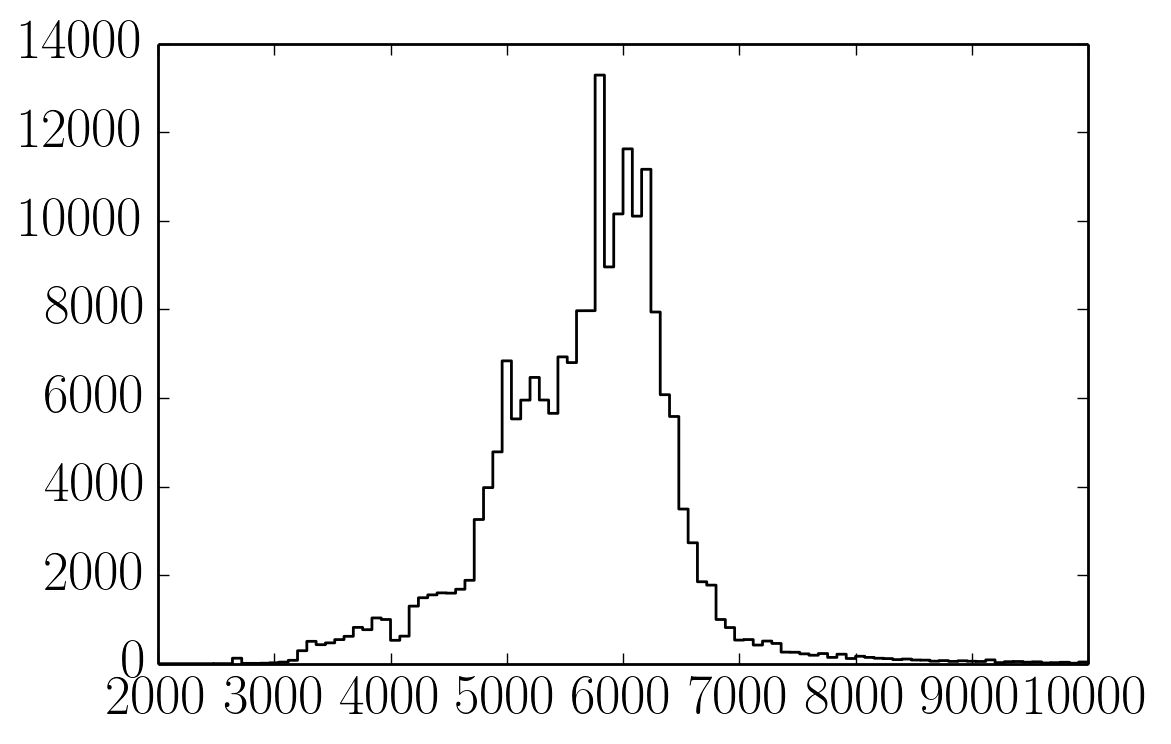

In [174]:
pl.hist(stlr.teff, 100, range=(2000, 10000), histtype="step", color="k");

In [135]:
star = stlr.iloc[10500]

In [166]:
x = np.exp(np.linspace(np.log(5.0), np.log(1000.), 50))
y = np.exp(np.linspace(np.log(0.005), np.log(0.1), 100))
X, Y = np.meshgrid(x, y, indexing="ij")

full_comp = np.zeros_like(X)

for _, star in stlr.iloc[:500].iterrows():
    depth_ppm = 1e6 * (Y / star.radius) ** 2
    snr = depth_ppm / star.rrmscdpp12p0 * np.sqrt(star.dataspan * star.dutycycle / X)
    comp = 1 / (1 + np.exp(2 * (7.1-snr)))

    bn1 = np.array([binom.pmf(1, star.dataspan / x0, star.dutycycle) for x0 in x])
    bn2 = np.array([binom.pmf(2, star.dataspan / x0, star.dutycycle) for x0 in x])

    comp *= ((1.0 - bn1 - bn2) * (star.dataspan / x > 2))[:, None]
    if not np.any(np.isnan(comp)):
        full_comp += comp

# G = 2945.4625385377644
# a = (G*period*period*star.mass/(4*np.pi*np.pi)) ** (1./3)

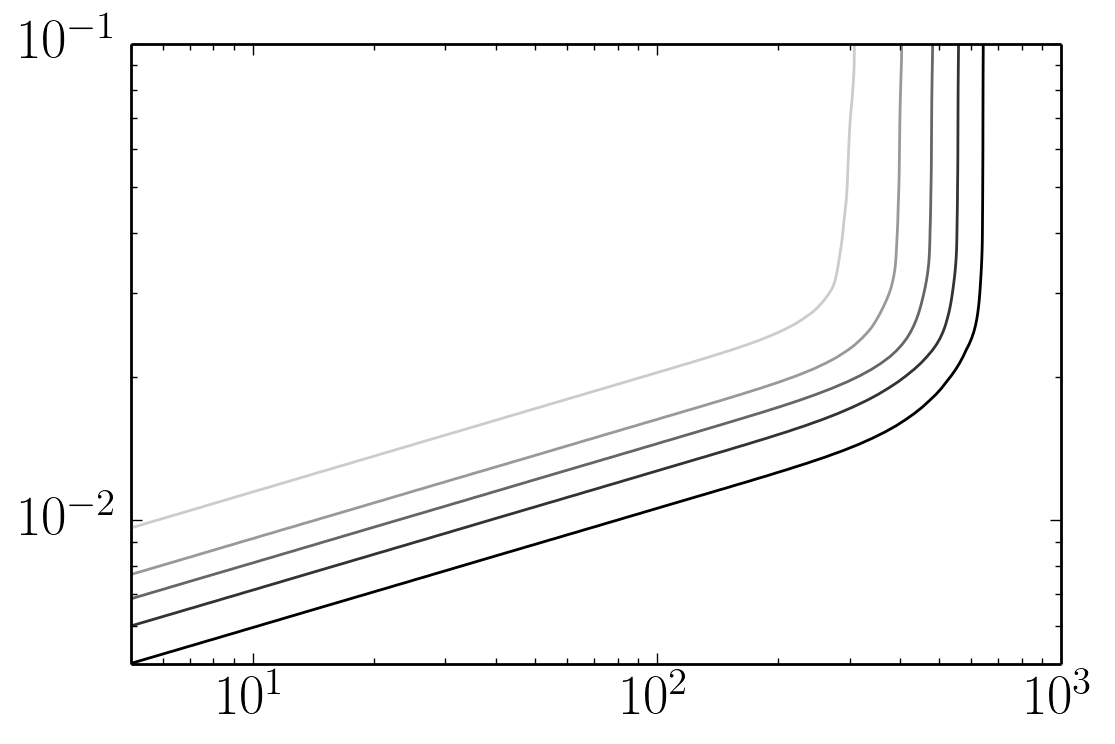

In [167]:
pl.contour(X, Y, full_comp / 500., cmap="gray")
pl.xscale("log")
pl.yscale("log")
pl.xlim(min(x), max(x))
pl.ylim(min(y), max(y))
# pl.colorbar();

In [168]:
full_comp.T/500.

array([[ 0.14902178,  0.13084417,  0.1136403 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17038448,  0.15125339,  0.13296351, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19279946,  0.17272024,  0.15349683, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.92531885,  0.92459072,  0.92392242, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.92620138,  0.92531201,  0.92448745, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.92707774,  0.92620578,  0.9252311 , ...,  0.        ,
         0.        ,  0.        ]])

In [151]:
star = stlr[stlr.kepid == 10154189]

In [153]:
star.dataspan

192   NaN
Name: dataspan, dtype: float64